# Number of guests prediction demo

Stripped-down version of [this notebook](https://www.kaggle.com/code/atasaygin/hotel-booking-demand-eda-and-of-guest-prediction).

**Performance** 
- Hotel booking demand dataset
    - Test MAPE City Hotel: 0.249210
    - Test MAPE Resort Hotel: 0.241623
- Lumen dataset `data/raw/lumen_dataset`

# Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error
import os

for dirname, _, filenames in os.walk('../data/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

../data/raw\booking_demand\hotel-booking-demand-eda-and-of-guest-prediction.ipynb
../data/raw\booking_demand\hotel_bookings.csv
../data/raw\lumen_dataset\export_df.parquet


In [14]:
data = pd.read_parquet('../data/raw/lumen_dataset/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [15]:
print(len(data))

119210


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hotel_id                       119210 non-null  int32         
 1   datum_dolaska                  119210 non-null  datetime64[ns]
 2   datum_kreiranja_rezervacije    119210 non-null  datetime64[ns]
 3   datum_odjave                   119210 non-null  datetime64[ns]
 4   datum_otkazivanja_rezervacije  44199 non-null   object        
 5   broj_odraslih_gostiju          119210 non-null  int64         
 6   broj_djece_gostiju             119210 non-null  float64       
 7   zemlja_gosta                   119210 non-null  object        
 8   kanal_prodaje_id               119210 non-null  int32         
 9   tip_sobe_id                    119210 non-null  int32         
 10  cijena_nocenja                 119210 non-null  float64       
 11  

In [17]:
len((data['cijena_nocenja'] /(data['broj_odraslih_gostiju']+data['broj_djece_gostiju'])).unique())

111609

In [18]:
len(data['cijena_nocenja'].unique())

111461

**Some features have wrong datatype. I need to fix that for the following steps.**

In [19]:
NaN = data.isna().sum()
NaN

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

# Data Cleaning

In [20]:
#data = data.drop(['company', 'agent'], axis=1)
data = data.dropna(subset=['zemlja_gosta', 'broj_djece_gostiju','datum_dolaska'], axis=0)
data = data.reset_index(drop=True)
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [21]:
print(len(data))
print(f"Resort ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City ima {len(data[data['hotel_id']==1])} zapisa")


119210
Resort ima 40047 zapisa
City ima 79163 zapisa


In [10]:
print(len(data[data['zemlja_gosta']=='0']))

552


In [11]:
# data = data[~(data['zemlja_gosta']=='0')]
# print(len(data))
# print(f"Resort ima {len(data[data['hotel_id']==0])} zapisa")
# print(f"City ima {len(data[data['hotel_id']==1])} zapisa")


118658
Resort ima 39583 zapisa
City ima 79075 zapisa


In [22]:
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)
data['broj_djece_gostiju'].dtype #It is correct now!

dtype('int32')

In [23]:
# Checking for the missing values after drops
NaN_updated = data.isna().sum()
NaN_updated

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

In [24]:
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703


# Creating New Features

In [25]:
# Calculating total guests for each record
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']
data['ukupno_gostiju'].head(10)

0    2
1    2
2    1
3    1
4    2
5    2
6    2
7    2
8    2
9    2
Name: ukupno_gostiju, dtype: int64

In [ ]:
print(len(data))

In [ ]:
# data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
# data['duljina_boravka'] = data['duljina_boravka'].dt.days
# data.head(10)


In [26]:
# Some data points include zero Total Guests, therefore I dropped them
data = data[data['ukupno_gostiju'] != 0]

In [27]:
# Total Number of Days Stayed -- ovo nemamo
# data['Total Stays'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']

dataNoCancel = data[~data['datum_otkazivanja_rezervacije'].notna()]
dataNoCancel = dataNoCancel.reset_index(drop=True)

In [28]:
print(len(dataNoCancel))

75011


In [29]:
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

In [30]:
print(len(dataResort))
print(len(dataCity))

40047
79163


In [31]:
dataResort.columns

Index(['hotel_id', 'datum_dolaska', 'datum_kreiranja_rezervacije',
       'datum_odjave', 'datum_otkazivanja_rezervacije',
       'broj_odraslih_gostiju', 'broj_djece_gostiju', 'zemlja_gosta',
       'kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja',
       'status_rezervacije', 'rezervacija_id', 'gost_id', 'ukupno_gostiju'],
      dtype='object')

In [32]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuestsResort = dataResort[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()
NumberOfGuestsWeeklyResort.head(10)

,ukupno_gostiju
datum_dolaska,
2015-07-05,471
2015-07-12,614
2015-07-19,732
2015-07-26,705
2015-08-02,781
2015-08-09,667
2015-08-16,798
2015-08-23,673
2015-08-30,672


#### kako to da brojevi gostiju toliko odudaraju od originalnog dataframea?
#### samo za city hotel

In [50]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuestsCity = dataCity[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('w').sum().to_frame()
# NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity[~(NumberOfGuestsWeeklyCity['ukupno_gostiju']==0)]
NumberOfGuestsWeeklyCity.head(10)

,ukupno_gostiju
datum_dolaska,
2015-01-04,44
2015-01-11,69
2015-01-18,85
2015-01-25,80
2015-02-01,44
2015-02-08,0
2015-02-15,0
2015-02-22,0
2015-03-01,0


# ARIMA Model for Predicting Future Number of Guests


In [51]:
# Dickey-Fuller Test to City Hotel Data
CityWeeklyValues = NumberOfGuestsWeeklyCity.values
result_city = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city[0])
print('p-value: %f' % result_city[1])
print('Critical Values:')
for key, value in result_city[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.145250
p-value: 0.226713
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


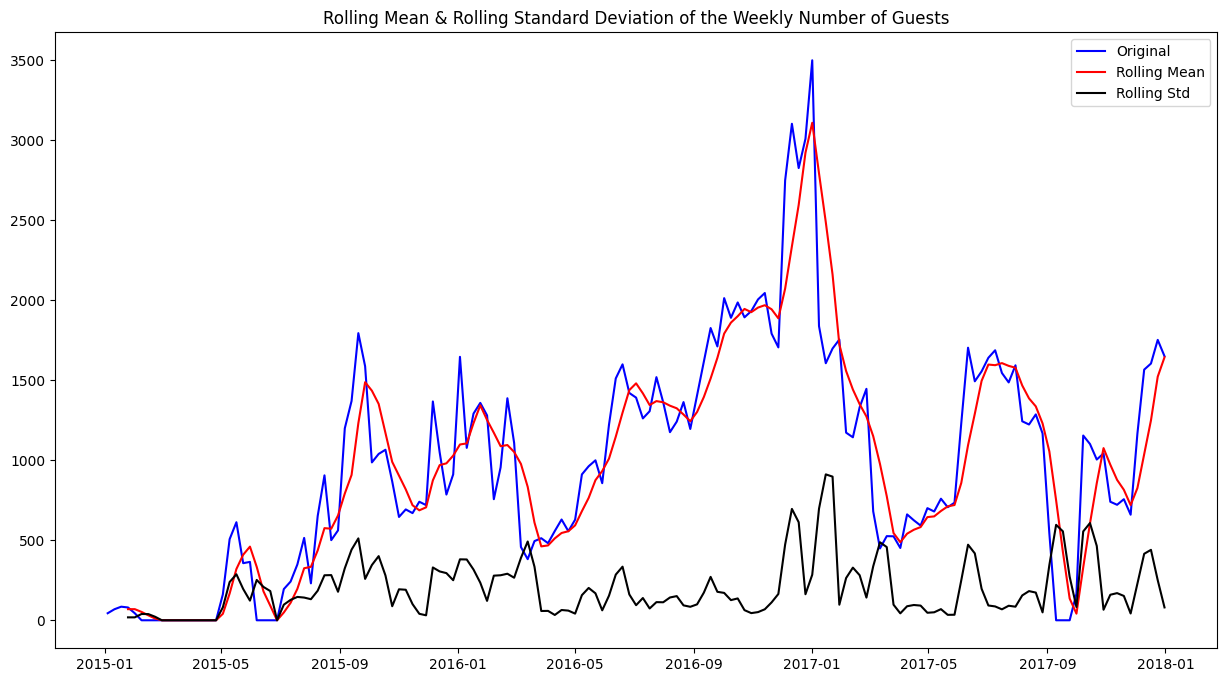

In [52]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsWeeklyCity.rolling(window=4).mean()
rolling_std = NumberOfGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests')
plt.show()

In [53]:
len(NumberOfGuestsWeeklyCity)

157

In [54]:
train_test_split_city = 110 # int(len(NumberOfGuestsWeeklyCity)*0.8)

trainCity = NumberOfGuestsWeeklyCity[:train_test_split_city]
testCity = NumberOfGuestsWeeklyCity[train_test_split_city:]

In [55]:
# Fit auto_arima function to NumberOfGuests_CityWeekly Dataset
stepwise_fit = auto_arima(trainCity['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1526.935, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1436.636, Time=0.90 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1544.551, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1447.030, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1433.054, Time=3.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1513.740, Time=2.15 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1435.044, Time=3.15 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1435.035, Time=3.34 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1462.463, Time=2.29 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1437.016, Time=3.93 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1435.537, Time=1.00 sec

Best model:  A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  110
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -711.527
Date:                            Sun, 11 Feb 2024   AIC                           1433.054
Time:                                    21:52:59   BIC                           1445.978
Sample:                                01-04-2015   HQIC                          1438.281
                                     - 02-05-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     99.8721     62.214      1.605      0.108     -22.065     221.809
ar.L1          0.7669      0.054     14.280      0.000       0.662       0.872
ar.S.L12      -0.5218      0.139     -3.755      0.000      -0.794      -0.249
ar.S.L24      -0.2777      0.158     -1.755      0.079      -0.588       0.032
sigma2       1.14e+05   1.33e+04      8.558      0.000    8.79e+04     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.30
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                            -0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
modelCity = ARIMA(trainCity['ukupno_gostiju'],
                  order=(3, 0, 0),
                  seasonal_order=(2, 1, 0, 12))

resultCity = modelCity.fit()

# Prediction of the Test data
predictionsCityTest = resultCity.predict(train_test_split_city, train_test_split_city + len(testCity) - 1, typ='levels').rename("Predictions")


# Prediction of Number of Guests (Test Data)


Text(0, 0.5, 'Number of Guests')

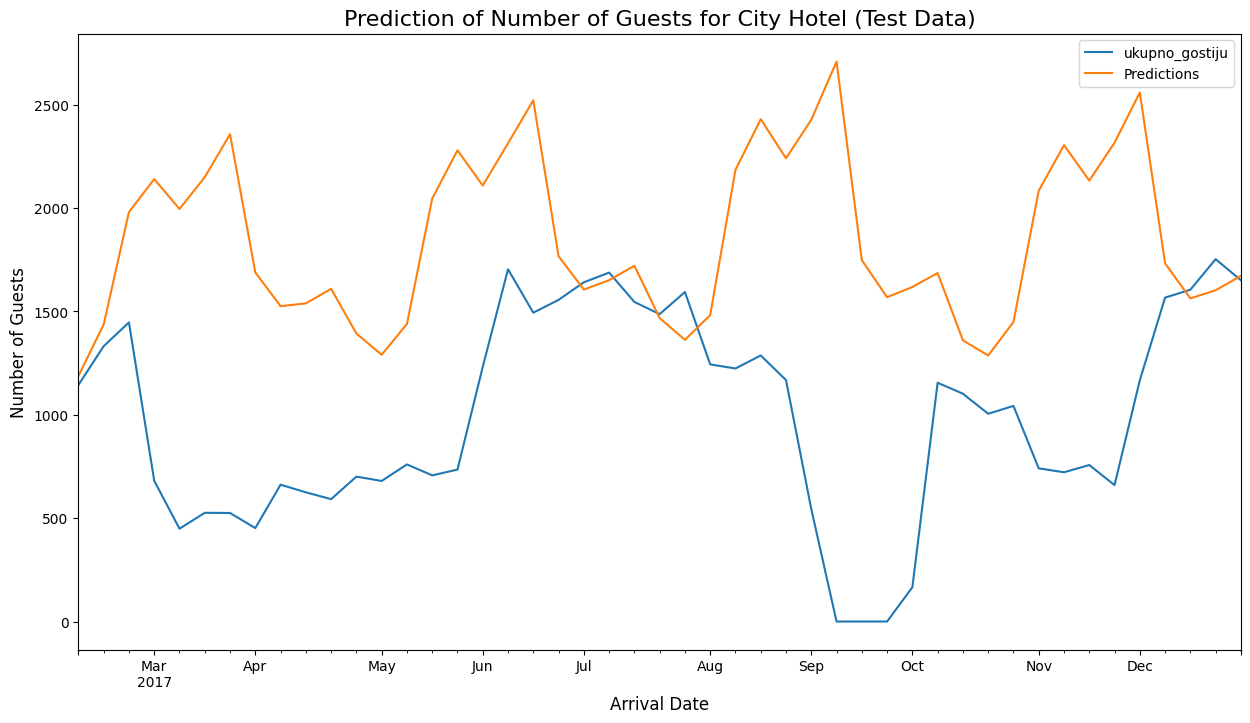

In [61]:
plt.figure(figsize=(15, 8))
testCity['ukupno_gostiju'].plot(legend=True)
predictionsCityTest.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel (Test Data)', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

# Prediction of Number of Guests


Text(0, 0.5, 'Number of Guests')

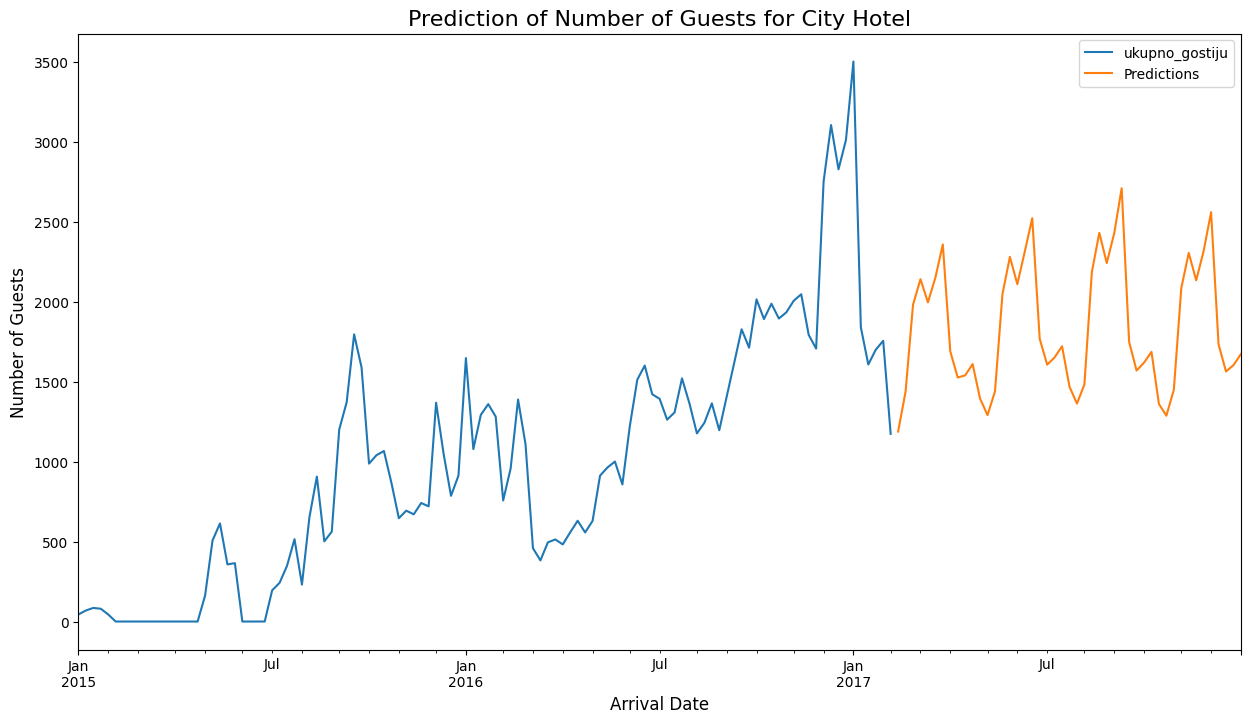

In [62]:
plt.figure(figsize=(15, 8))
trainCity['ukupno_gostiju'].plot(legend=True)
predictionsCityTest.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [63]:
MeanAbsPercentageErrCity_test = mean_absolute_percentage_error(testCity, predictionsCityTest)
print('Test MAPE City Hotel: %f' % MeanAbsPercentageErrCity_test)

Test MAPE City Hotel: 577425740603156736.000000


# ARIMA Model for Predicting Future Number of Guests


In [ ]:
# Dickey-Fuller Test to City Hotel Data
ResortWeeklyValues = NumberOfGuestsWeeklyResort.values
result_resort = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort[0])
print('p-value: %f' % result_resort[1])
print('Critical Values:')
for key, value in result_resort[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean_resort = NumberOfGuestsWeeklyResort.rolling(window=4).mean()
rolling_std_resort = NumberOfGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests')
plt.show()

In [ ]:
len(NumberOfGuestsWeeklyResort)

In [ ]:
trainResort = NumberOfGuestsWeeklyResort[:90]
testResort = NumberOfGuestsWeeklyResort[90:]

In [ ]:
# Fit auto_arima function to NumberOfGuests_ResortWeekly Dataset
stepwise_fit = auto_arima(trainResort['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

In [ ]:
modelResort = ARIMA(trainResort['ukupno_gostiju'],
                    order=(2, 0, 0),
                    seasonal_order=(2, 1, 0, 12))

resultResort = modelResort.fit()

predictionsResortTest = resultResort.predict(90, 113, typ='levels').rename("Predictions")


# Prediction of Number of Guests (Resort Test Data)


In [ ]:
plt.figure(figsize=(15, 8))
testResort['ukupno_gostiju'].plot(legend=True)
predictionsResortTest.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel (Test Data)', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

# Prediction of Number of Guests for Resort Hotel 


In [ ]:
plt.figure(figsize=(15, 8))
trainResort['ukupno_gostiju'].plot(legend=True)
predictionsResortTest.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [ ]:
MeanAbsPercentageErrResort_test = mean_absolute_percentage_error(testResort, predictionsResortTest)
print('Test MAPE Resort Hotel: %f' % MeanAbsPercentageErrResort_test)